In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [4]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
import pandas as pd
import numpy as np
from nsetools import Nse
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [7]:
# Fetch data from NSE (assuming historical data is available)
nse = Nse()
symbol = 'RELIANCE'


In [10]:
# Placeholder for historical data
# For demonstration, generate synthetic data
dates = pd.date_range(start='1/1/2020', periods=365, freq='D')
np.random.seed(0)
close_prices = np.random.normal(loc=2000, scale=50, size=len(dates))
df = pd.DataFrame(data={'Date': dates, 'Close': close_prices})

In [11]:
# Convert date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.index.freq = 'D' # Explicitly set the frequency

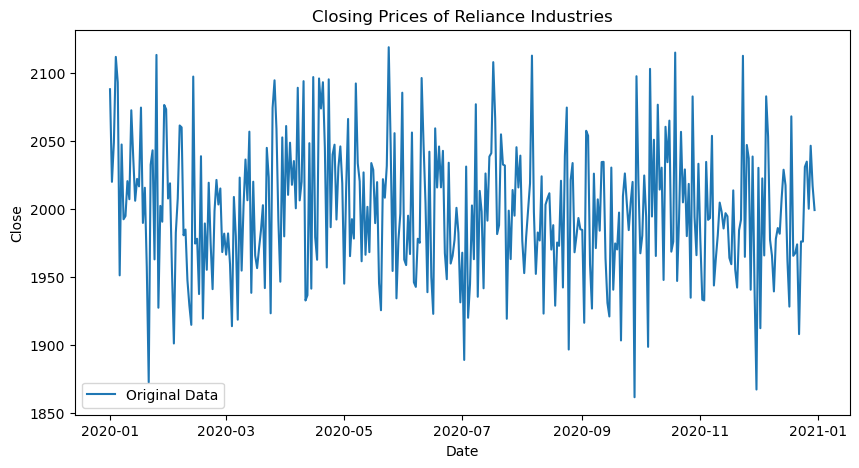

In [13]:
# Plot original data
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Original Data')
plt.title('Closing Prices of Reliance Industries')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


In [14]:
# Fit ARIMA model
arima_model = ARIMA(df['Close'], order=(5,1,0))
arima_result = arima_model.fit()

In [15]:
# Get ARIMA predictions
df['ARIMA_Prediction'] = arima_result.predict(start=0, end=len(df)-1,
dynamic=False)

In [16]:
# Calculate residuals
df['Residuals'] = df['Close'] - df['ARIMA_Prediction']

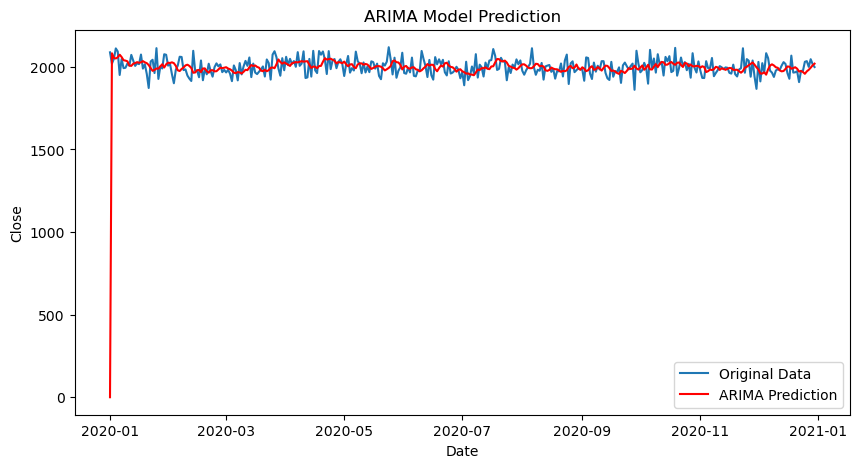

In [38]:
# Plot ARIMA results
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Original Data')
plt.plot(df['ARIMA_Prediction'], label='ARIMA Prediction', color='red')
plt.title('ARIMA Model Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


In [19]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data =scaler.fit_transform(df['Residuals'].values.reshape(-1,1))

In [25]:
# Prepare dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [26]:
time_step = 10
X, Y = create_dataset(scaled_data, time_step)

In [28]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

In [29]:
# Create LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
# Train the model
model.fit(X, Y, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
354/354 - 9s - 26ms/step - loss: 7.1465e-04
Epoch 2/10
354/354 - 3s - 8ms/step - loss: 6.5666e-04
Epoch 3/10
354/354 - 3s - 8ms/step - loss: 6.2693e-04
Epoch 4/10
354/354 - 3s - 9ms/step - loss: 6.3786e-04
Epoch 5/10
354/354 - 3s - 8ms/step - loss: 6.3593e-04
Epoch 6/10
354/354 - 3s - 9ms/step - loss: 6.2022e-04
Epoch 7/10
354/354 - 3s - 8ms/step - loss: 6.1501e-04
Epoch 8/10
354/354 - 3s - 9ms/step - loss: 6.0614e-04
Epoch 9/10
354/354 - 3s - 9ms/step - loss: 6.1313e-04
Epoch 10/10
354/354 - 3s - 9ms/step - loss: 5.8208e-04


In [32]:
# Predict using the LSTM model
train_predict = model.predict(X)
train_predict = scaler.inverse_transform(train_predict)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


In [33]:
# Append LSTM predictions to the dataframe
df['LSTM_Prediction'] = np.nan
df['LSTM_Prediction'].iloc[time_step+1:] = train_predict[:, 0]

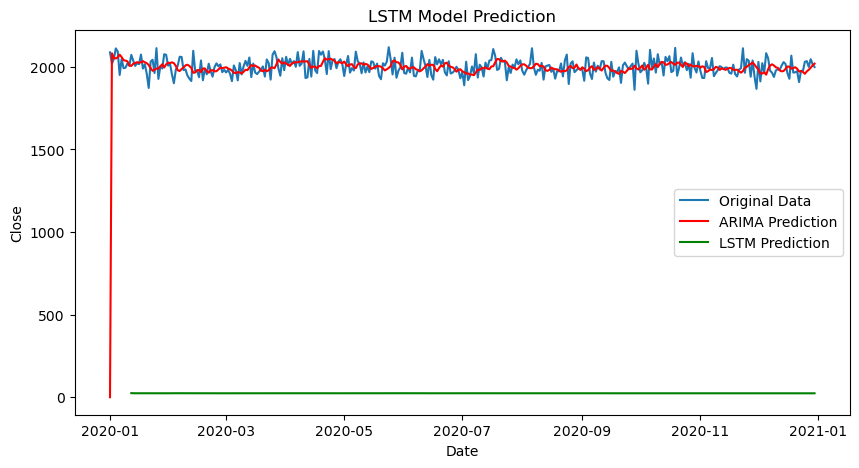

In [40]:
# Plot LSTM results
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Original Data')
plt.plot(df['ARIMA_Prediction'], label='ARIMA Prediction', color='red')
plt.plot(df['LSTM_Prediction'], label='LSTM Prediction', color='green')
plt.title('LSTM Model Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


In [36]:
# Combine ARIMA and LSTM predictions
df['Combined_Prediction'] = df['ARIMA_Prediction'] + df['LSTM_Prediction'].fillna(0)

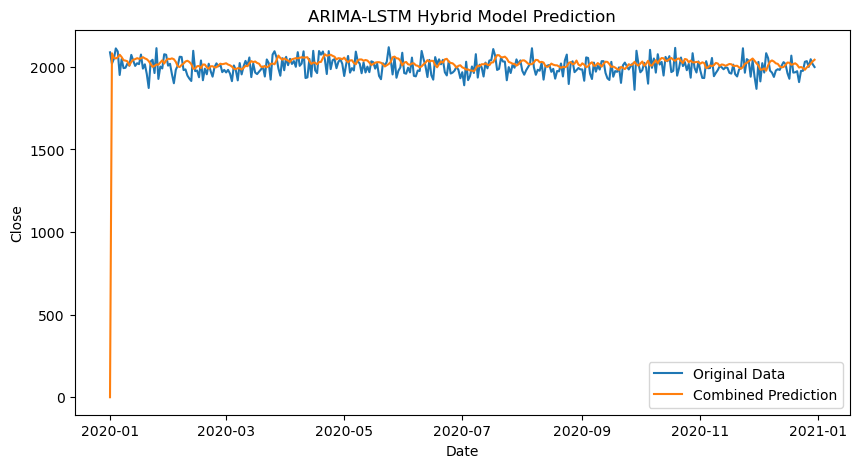

In [42]:
# Plot combined results
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Original Data')
plt.plot(df['Combined_Prediction'], label='Combined Prediction')
plt.title('ARIMA-LSTM Hybrid Model Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()
